#Imports & Notes:

In [134]:
# Write model, train, test loop
# Write MineSweeper_Model_Bot (game play)
# Reinforcement learning can be useful

import random
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

#Logic Bot:

In [135]:
class MineSweeper_Logic_Bot:
    def __init__(self, rows, cols, num_of_mines, allow_mines, allow_print):
        """
        Initialize the Minesweeper Logic Bot with the given parameters.
        :param rows: Number of rows in the minesweeper board.
        :param cols: Number of columns in the minesweeper board.
        :param num_of_mines: Total number of mines to be placed on the board.
        :param allow_mines: Boolean indicating whether the game should continue after hitting a mine.
        :param allow_print: Boolean indicating whether the board should be printed after each move.
        """
        self.rows = rows
        self.cols = cols
        self.num_of_mines = num_of_mines
        self.allow_mines = allow_mines
        self.allow_print = allow_print
        self.adj_directions = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
        self.reset()

    def reset(self):
        """
        Reset or initialize the board at the start of a new game. This method sets up the board, mines,
        and other game variables to their starting state.
        """
        self.board = [['#' for _ in range(self.cols)] for _ in range(self.rows)]
        self.cells_remaining = set((i, j) for i in range(self.rows) for j in range(self.cols))
        self.inferred_safe = set()
        self.inferred_mine = set()
        self.clue_number = {}
        self.revealed_cells = set()
        self.mines_triggered = set()

        self.input_states = []
        self.output_states = []

        # Select the initial safe cell randomly and set it up without a mine
        r, c = random.randint(0, self.rows - 1), random.randint(0, self.cols - 1)
        self.initial_safe_cell(r, c)

    def initial_safe_cell(self, r, c):
        """
        Set up the initial safe cell and its neighbors. The selected cell and its neighbors are cleared
        of mines and marked safe.
        :param r: Row index of the initially selected safe cell.
        :param c: Column index of the initially selected safe cell.
        """
        self.board[r][c] = '0'  # Set the clue of the initial cell to 0, indicating no adjacent mines
        self.cells_remaining.remove((r, c))
        self.revealed_cells.add((r, c))
        self.clue_number[(r, c)] = 0

        valid_neighbors = self.get_neighbors((r, c))
        self.inferred_safe.update(valid_neighbors)
        for nei in valid_neighbors:
            self.cells_remaining.remove(nei)

        # Print the initial board setup if allowed
        if self.allow_print:
            self.print_board()

        # Exclude the initial safe cell and its neighbors from being potential mine locations
        possible_mine_locations = list(self.cells_remaining - self.inferred_safe)
        self.mines = set(random.sample(possible_mine_locations, self.num_of_mines))

    def get_neighbors(self, cell):
        """
        Get all valid neighboring cells of a given cell.
        :param cell: A tuple (r, c) representing the cell for which neighbors are to be found.
        :return: A set of tuples representing the valid neighbors of the given cell.
        """
        r, c = cell
        return {(r + dr, c + dc) for dr, dc in self.adj_directions if 0 <= r + dr < self.rows and 0 <= c + dc < self.cols}

    def print_board(self):
        """
        Print the current state of the minesweeper board.
        """
        for row in self.board:
            print(' '.join(str(cell) for cell in row))
        print()

    def reveal_clue(self, reveal_cell):
        valid_neighbors = self.get_neighbors(reveal_cell)
        return sum(1 for nei in valid_neighbors if nei in self.mines)

    def play(self):
        while True:
            if (self.rows*self.cols)-self.num_of_mines == len(self.revealed_cells):
                return len(self.revealed_cells), len(self.mines_triggered), self.input_states, self.output_states

            if self.inferred_safe:
                reveal_cell = self.inferred_safe.pop()
            else:
                reveal_cell = self.cells_remaining.pop()

            if reveal_cell in self.mines:
                self.mines_triggered.add(reveal_cell)
                r_m, c_m = reveal_cell
                self.board[r_m][c_m] = 'M'
                if not self.allow_mines:
                    if self.allow_print:
                        self.print_board()
                    self.generate_data()
                    return len(self.revealed_cells), len(self.mines_triggered), self.input_states, self.output_states
            else:
                self.revealed_cells.add(reveal_cell)
                reveal_cell_clue = self.reveal_clue(reveal_cell)
                self.clue_number[reveal_cell] = reveal_cell_clue
                r, c = reveal_cell
                self.board[r][c] = str(reveal_cell_clue)

            if self.allow_print:
                self.print_board()
            self.generate_data()

            for cell, clue in self.clue_number.items():
                valid_neighbors = self.get_neighbors(cell)
                num_nei_inferred_mines = sum(1 for nei in valid_neighbors if nei in self.inferred_mine)
                num_unrevealed_nei = sum(1 for nei in valid_neighbors if nei not in self.revealed_cells)

                if (clue - num_nei_inferred_mines) == num_unrevealed_nei:
                    for nei in valid_neighbors:
                        if nei not in self.revealed_cells:
                            self.inferred_mine.add(nei)
                            self.cells_remaining.remove(nei)
                            # self.cells_remaining.discard(nei)

                num_nei_revealed_or_inferred_safe = 0
                for nei in valid_neighbors:
                    if nei in self.revealed_cells or nei in self.inferred_safe:
                        num_nei_revealed_or_inferred_safe += 1

                if (len(valid_neighbors) - clue) - num_nei_revealed_or_inferred_safe == num_unrevealed_nei:
                    for nei in valid_neighbors:
                        if nei not in self.revealed_cells:
                            self.inferred_safe.add(nei)
                            self.cells_remaining.remove(nei)

    def generate_data(self):
        # Input: Convert self.board -> For clue #: 0 to 8, For Unclicked: 9, For Mine: 10
        # Output: Convert self.board -> For Mine: 0, For Safe: 1
        temp_i = copy.deepcopy(self.board)
        for i, row in enumerate(self.board):
            for j, element in enumerate(row):
                if element == 'M':
                    num = 10
                elif element == '#':
                    num = 9
                else:
                    num = int(element)
                temp_i[i][j] = num
        self.input_states.append(temp_i)

        temp_o = copy.deepcopy(self.board)
        for i, row in enumerate(self.board):
            for j, element in enumerate(row):
                temp_o[i][j] = 0 if (i, j) in self.mines else 1
        self.output_states.append(temp_o)

    def model_play(self, model, embeddings):
        model.eval()
        for cell in self.inferred_safe:
            self.cells_remaining.add(cell)
        while self.inferred_safe:
            self.inferred_safe.pop()

        while True:
            if (self.rows * self.cols - self.num_of_mines) == len(self.revealed_cells):
                return len(self.revealed_cells), len(self.mines_triggered), self.input_states, self.output_states

            c_s = [[9 if cell == '#' else (10 if cell == 'M' else int(cell)) for cell in row] for row in self.board]
            current_state = torch.tensor(c_s, dtype=torch.long)
            embedded_input = embeddings(current_state).unsqueeze(0)  # Add batch dimension
            board_tensor = embedded_input.permute(0, 3, 1, 2)  # Rearrange to [batch, channels, height, width]

            # Predict the safest cell to reveal next
            with torch.no_grad():
                predictions = model(board_tensor).squeeze(0)  # Remove batch dimension

            # Choose the cell with the highest safety score
            max_prob = 0
            cell_to_reveal = None
            for r in range(self.rows):
                for c in range(self.cols):
                    if (r, c) in self.cells_remaining and predictions[r][c] > max_prob:
                        max_prob = predictions[r][c]
                        cell_to_reveal = (r, c)
            self.cells_remaining.remove(cell_to_reveal)

            if cell_to_reveal in self.mines:
                self.mines_triggered.add(cell_to_reveal)
                r, c = cell_to_reveal
                self.board[r][c] = 'M'
                if not self.allow_mines:
                    if self.allow_print:
                        self.print_board()
                    self.generate_data()
                    return len(self.revealed_cells), len(self.mines_triggered), self.input_states, self.output_states
            else:
                r, c = cell_to_reveal
                self.revealed_cells.add(cell_to_reveal)
                if cell_to_reveal in self.cells_remaining:
                    self.revealed_cells.add(cell_to_reveal)
                    clue = self.reveal_clue(cell_to_reveal)
                    self.board[r][c] = str(clue)

            if self.allow_print:
                self.print_board()
            self.generate_data()

In [136]:
def run_bot_and_get_stats(rows, cols, num_of_mines, allow_mines, allow_board_print, num_game_play, flag_logic_bot, model, embeddings):
    won = 0
    avg_cells_opened = 0
    avg_mines_triggered = 0

    input_states = []
    output_states = []

    for i in range(num_game_play):
        bot = MineSweeper_Logic_Bot(rows, cols, num_of_mines, allow_mines, allow_board_print)
        if flag_logic_bot:
            num_cells_opened, num_mines_triggered, i_states, o_states = bot.play()
        else:
            num_cells_opened, num_mines_triggered, i_states, o_states = bot.model_play(model, embeddings)
        if num_cells_opened == ((rows*cols)-num_of_mines) and num_mines_triggered == 0:
            won += 1
        avg_cells_opened += num_cells_opened
        avg_mines_triggered += num_mines_triggered
        input_states.extend(i_states)
        output_states.extend(o_states)

    avg_cells_opened /= num_game_play
    avg_mines_triggered /= num_game_play
    print(f"Count Logic Bot Won: {won}")
    print(f"Avg. Cell's Opened: {avg_cells_opened}, Avg. Mines Triggered: {avg_mines_triggered}")
    print(f"Data Points Generated: {len(input_states)}")
    return input_states, output_states, won, avg_cells_opened, avg_mines_triggered

In [137]:
# Easy Level - Game ends after a mine is triggered

# Generate Train Dataset (Approx. 80%)
print("Generating Train Dataset ... ")
input_states_train, output_states_train, won_train, avg_cells_opened_train, avg_mines_triggered_train = run_bot_and_get_stats(9, 9, 10, False, False, 2000, True, None, None)
print()

print("Generating Test Dataset ... ")
# Generate Test Dataset (Approx. 20%)
input_states_test, output_states_test, won_test, avg_cells_opened_test, avg_mines_triggered_test = run_bot_and_get_stats(9, 9, 10, False, False, 400, True, None, None)

tensor_x_train = torch.Tensor(input_states_train)
# tensor_x_train = tensor_x_train.unsqueeze(1)
tensor_y_train = torch.Tensor(output_states_train)
train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

tensor_x_test = torch.Tensor(input_states_test)
# tensor_x_test = tensor_x_test.unsqueeze(1)
tensor_y_test = torch.Tensor(output_states_test)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Generating Train Dataset ... 
Count Logic Bot Won: 76
Avg. Cell's Opened: 50.98, Avg. Mines Triggered: 0.962
Data Points Generated: 101884

Generating Test Dataset ... 
Count Logic Bot Won: 18
Avg. Cell's Opened: 50.78, Avg. Mines Triggered: 0.955
Data Points Generated: 20294


In [138]:
embedding_dim = 2
num_of_embeddings = 11
embeddings = nn.Embedding(num_of_embeddings, embedding_dim)

class Minesweeper_Model_Easy(nn.Module):
    def __init__(self, embedding_dim):
        super(Minesweeper_Model_Easy, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=embedding_dim, out_channels=8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(9 * 9 * 16, 9 * 9)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = x.reshape(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        return x.reshape(-1, 9, 9)

def get_output(embeddings, model, x):
    # x should be long tensor of indices with shape [batch_size, 9, 9]
    x = embeddings(x)  # Embed the input indices
    x = x.permute(0, 3, 1, 2)  # Rearrange dimensions to [batch_size, channels, height, width]
    return model(x)

In [139]:
# Initialize model
model_easy = Minesweeper_Model_Easy(embedding_dim)
print(model_easy)
print()
# Calculate and print the total number of parameters
total_params = sum(p.numel() for p in model_easy.parameters())
print("Total number of parameters: ", total_params)

# Define optimizers
model_easy_optimizer = torch.optim.SGD(model_easy.parameters(), lr=0.01)
embedding_optimizer = torch.optim.SGD(embeddings.parameters(), lr=0.01)

criterion = nn.BCELoss()

Minesweeper_Model_Easy(
  (conv1): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1296, out_features=81, bias=True)
)

Total number of parameters:  106425


In [140]:
train_losses = []
test_losses = []

def train_and_test(model, embeddings, train_dataloader, test_dataloader, model_optimizer, embedding_optimizer, criterion, epochs, train_embeddings):
    for epoch in range(epochs):
        # Set model to training mode
        model.train()

        # Choose the right optimizer based on what we're training
        optimizer = embedding_optimizer if train_embeddings else model_optimizer

        # Ensure only the necessary parts are trainable
        set_requires_grad(embeddings, train_embeddings)
        set_requires_grad(model, not train_embeddings)

        # Training phase
        total_train_loss = 0
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.long(), targets.float()  # Correct data types
            optimizer.zero_grad()
            outputs = get_output(embeddings, model, inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)  # Store train loss for plotting

        # Testing phase
        model.eval()  # Set model to evaluation mode
        total_test_loss = 0
        with torch.no_grad():
            for inputs, targets in test_dataloader:
                inputs, targets = inputs.long(), targets.float()
                outputs = get_output(embeddings, model, inputs)
                loss = criterion(outputs, targets)
                total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(test_dataloader)
        test_losses.append(avg_test_loss)  # Store test loss for plotting

        # Print average losses after each epoch
        print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}')

def set_requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad = value

In [141]:
for _ in range(2):
    print("Training Network Only (Not Embeddings) ...")
    set_requires_grad(model_easy, True)
    set_requires_grad(embeddings, False)
    train_and_test(model_easy, embeddings, train_dataloader, test_dataloader, model_easy_optimizer, embedding_optimizer, criterion, 10, False)

    print("Training Embeddings Only (Not Network) ...")
    set_requires_grad(model_easy, False)
    set_requires_grad(embeddings, True)
    train_and_test(model_easy, embeddings, train_dataloader, test_dataloader, model_easy_optimizer, embedding_optimizer, criterion, 5, True)

    print("Training Network Only (Not Embeddings) ...")
    set_requires_grad(model_easy, True)
    set_requires_grad(embeddings, False)
    train_and_test(model_easy, embeddings, train_dataloader, test_dataloader, model_easy_optimizer, embedding_optimizer, criterion, 10, False)

Training Network Only (Not Embeddings) ...
Epoch 1: Train Loss = 0.3837, Test Loss = 0.3738
Epoch 2: Train Loss = 0.3696, Test Loss = 0.3704
Epoch 3: Train Loss = 0.3643, Test Loss = 0.3655
Epoch 4: Train Loss = 0.3572, Test Loss = 0.3590
Epoch 5: Train Loss = 0.3485, Test Loss = 0.3510
Epoch 6: Train Loss = 0.3389, Test Loss = 0.3432
Epoch 7: Train Loss = 0.3294, Test Loss = 0.3355
Epoch 8: Train Loss = 0.3207, Test Loss = 0.3287
Epoch 9: Train Loss = 0.3128, Test Loss = 0.3229
Epoch 10: Train Loss = 0.3057, Test Loss = 0.3176
Training Embeddings Only (Not Network) ...
Epoch 1: Train Loss = 0.3018, Test Loss = 0.3165
Epoch 2: Train Loss = 0.3014, Test Loss = 0.3164
Epoch 3: Train Loss = 0.3013, Test Loss = 0.3161
Epoch 4: Train Loss = 0.3012, Test Loss = 0.3163
Epoch 5: Train Loss = 0.3012, Test Loss = 0.3158
Training Network Only (Not Embeddings) ...
Epoch 1: Train Loss = 0.2975, Test Loss = 0.3104
Epoch 2: Train Loss = 0.2909, Test Loss = 0.3055
Epoch 3: Train Loss = 0.2849, Test Lo

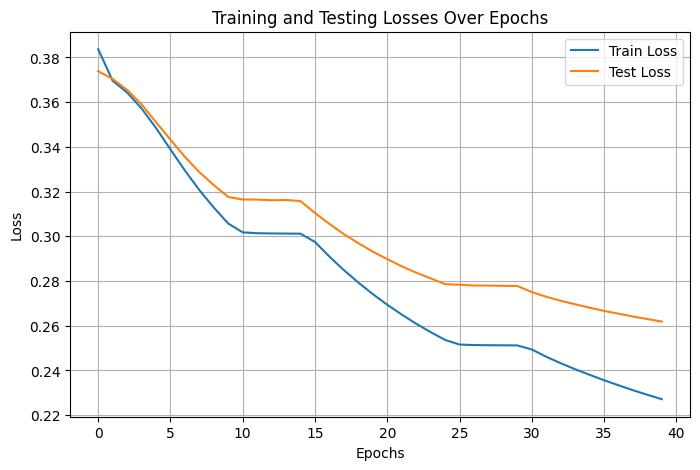

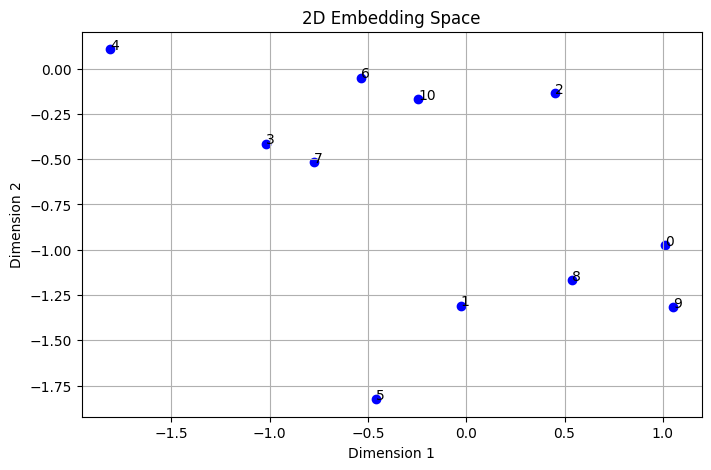

In [145]:
# Plot training and testing losses
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot embeddings in 2D space
embed_vectors = embeddings.weight.data.cpu().numpy()
plt.figure(figsize=(8, 5))
plt.scatter(embed_vectors[:, 0], embed_vectors[:, 1], c='blue', marker='o')
for i, txt in enumerate(range(0, 11)):
    plt.annotate(txt, (embed_vectors[i, 0], embed_vectors[i, 1]))
plt.title('2D Embedding Space')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

In [143]:
# Model Performance on Easy Level - Game ends after a mine is triggered
_, _, won, avg_cells_opened, avg_mines_triggered = run_bot_and_get_stats(9, 9, 10, False, False, 2000, False, model_easy, embeddings)

Count Logic Bot Won: 0
Avg. Cell's Opened: 13.188, Avg. Mines Triggered: 1.0
Data Points Generated: 26376
